In [5]:
import numpy as np  
import matplotlib.pyplot as plt
from PIL import Image

In [1]:
import os

file_names = os.listdir('./data/img_align_celeba')
img_paths = ['./data/img_align_celeba/' + file_name for file_name in file_names]
len(img_paths)

70560

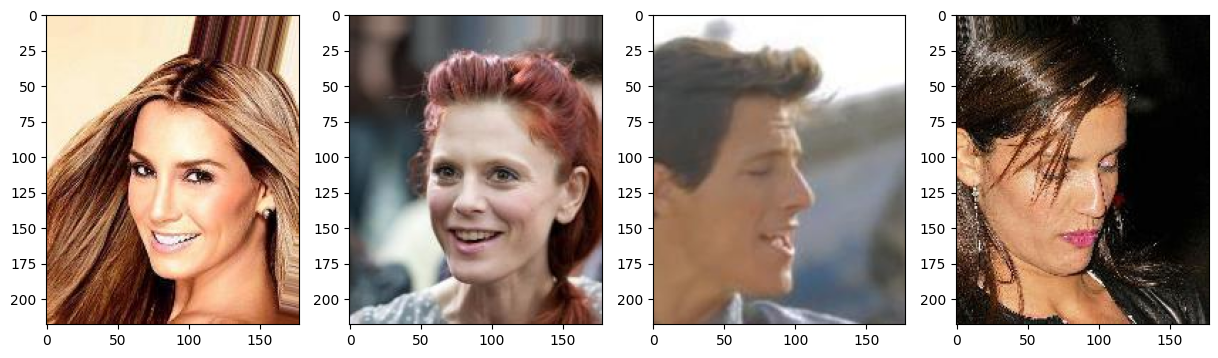

In [53]:
import matplotlib.pyplot as plt

def show_images(file_names, num_samples=4, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15, 15))
    for i, img_path in enumerate(file_names):
        if i == num_samples:
            break
        img = Image.open(img_path)
        img_np = np.array(img)
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_np)

def show_masked_images(img_with_mask, num_samples=4, cols=4):
    # Nếu tensor đang ở GPU, chuyển về CPU
    if img_with_mask.is_cuda:
        img_with_mask = img_with_mask.cpu()
    rows = (num_samples + cols - 1) // cols

    plt.figure(figsize=(15, 15))
    for i, img in enumerate(img_with_mask):
        # Unnormalize ảnh: với normalization (img - 0.5)/0.5, ta thực hiện: img*0.5 + 0.5
        img = img * 0.5 + 0.5
        # Chuyển đổi tensor từ (C, H, W) sang (H, W, C) để hiển thị bằng matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np)
        plt.axis('off')
    plt.show()
show_images(img_paths)

## Create data loader

In [10]:
num_train, num_val = 1000, 100  # demo with small data
train_imgpaths = img_paths[: num_train]
val_imgpaths = img_paths[num_train: num_train + num_val]

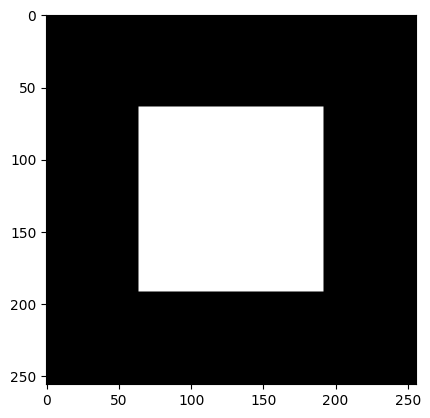

In [26]:
def bbox2mask(img_shape, bbox):
    """
    img_shape: (h, w, c)
    bbox: (x1, y1, w, h)
    """
    h_img, w_img = img_shape
    x1, y1, w, h = bbox
    mask = np.zeros((h_img, w_img), dtype=np.uint8)
    mask[y1:y1 + h, x1:x1 + w] = 1
    return mask


test_mask = bbox2mask((256, 256), (256//4, 256//4, 256//2, 256//2))
plt.imshow(test_mask, cmap='gray')

In [55]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class InpaintingDataset():
    def __init__(self, img_paths, mask_mode, data_len=100, image_size=[256, 256]):
        if data_len > 0:
            self.img_paths = img_paths[:int(data_len)]
        else:
            self.img_paths = img_paths

        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.mask_mode = mask_mode
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        img_with_mask = torch.where(mask[0] == 0, img, torch.tensor( # mask[0] : [h, w] broadcast-> [3, h, w] where with-> [3, h, w]
            0, dtype=img.dtype, device=img.device))
        
        return img_with_mask, mask

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        if self.mask_mode == 'center':
            h, w = self.image_size
            mask = bbox2mask(self.image_size, (h//4, w//4, h//2, w//2))
        else:
            raise NotImplementedError(
                f'Mask mode {self.mask_mode} has not been implemented.')
        return torch.from_numpy(mask).unsqueeze(0)

In [56]:
from torch.utils.data import DataLoader
train_dataset = InpaintingDataset(train_imgpaths, mask_mode='center')
val_dataset = InpaintingDataset(val_imgpaths, mask_mode='center')

BATCH_SIZE = 4
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Shape của img_with_mask: torch.Size([4, 3, 256, 256])
Shape của mask: torch.Size([1, 256, 256])


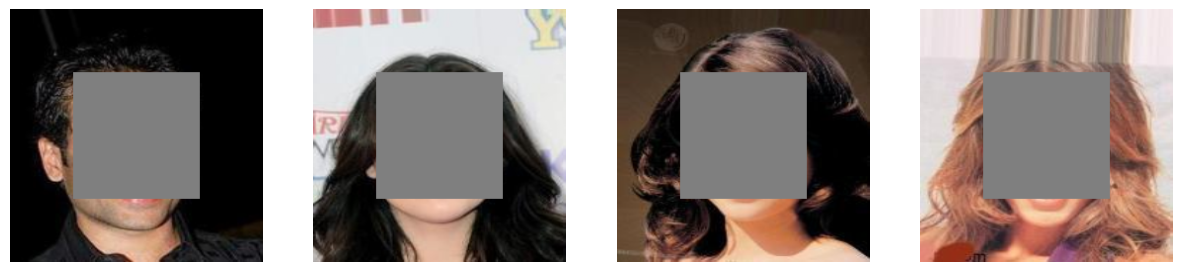

In [57]:
# Lấy iterator từ train_loader
data_iter = iter(train_loader)

# Lấy một batch (img_with_mask, mask) từ iterator
img_with_mask, mask = next(data_iter)

# In ra kích thước của các tensor để kiểm tra
print("Shape của img_with_mask:", img_with_mask.shape)
print("Shape của mask:", mask[0].shape)

# Hiển thị ảnh với mask
show_masked_images(img_with_mask, num_samples=4, cols=4)